In [ ]:
!pip install opencv-python

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
img_parking = cv2.imread('parking.png')
img_parking_rgb = cv2.cvtColor(img_parking, cv2.COLOR_BGR2RGB)

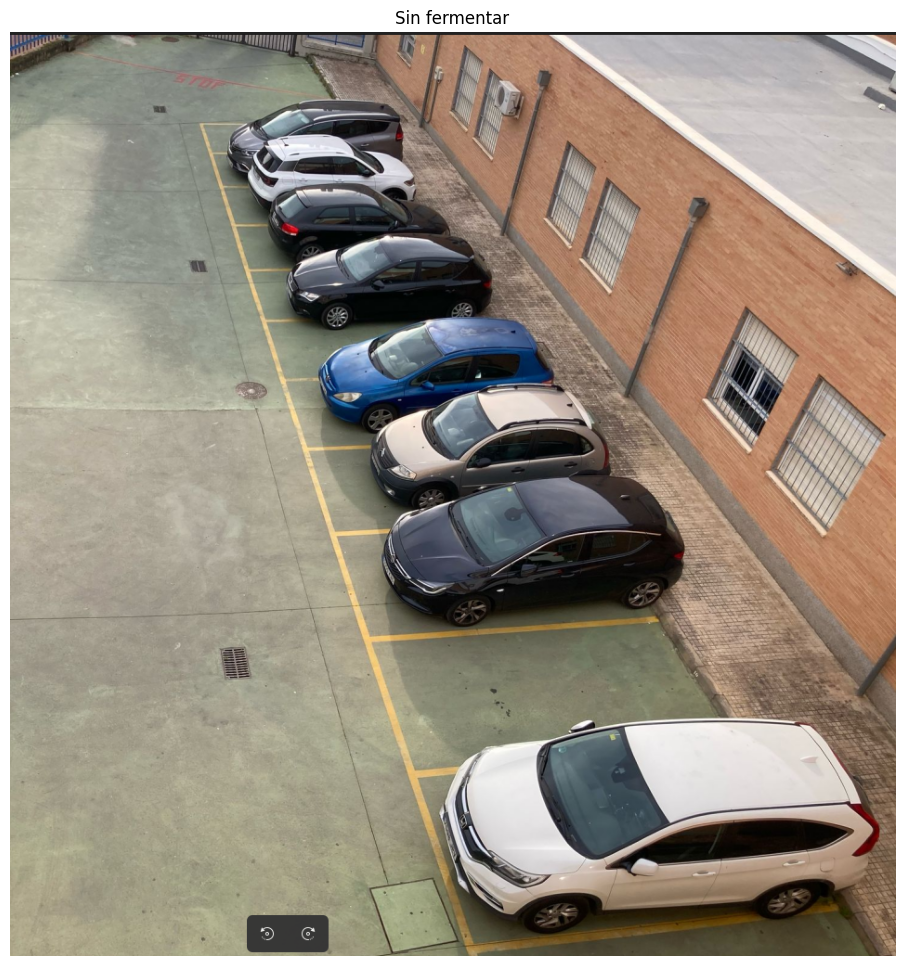

In [ ]:
plt.figure(figsize=(45,12))
plt.imshow(img_parking_rgb)
plt.title("Sin fermentar")
plt.axis("off")

plt.show()

# Detección de bordes con canny

In [ ]:
# Convertir a escala de grises y aplicar filtro Gaussiano
gray = cv2.cvtColor(img_parking, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

In [ ]:
# Detectar bordes con Canny
edges = cv2.Canny(blurred, 50, 150)

# Aplicar detección de líneas con Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=60, maxLineGap=10)

# Dibujar las líneas detectadas sobre la imagen original
img_lines = img_parking_rgb.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img_lines, (x1, y1), (x2, y2), (255, 0, 0), 3)

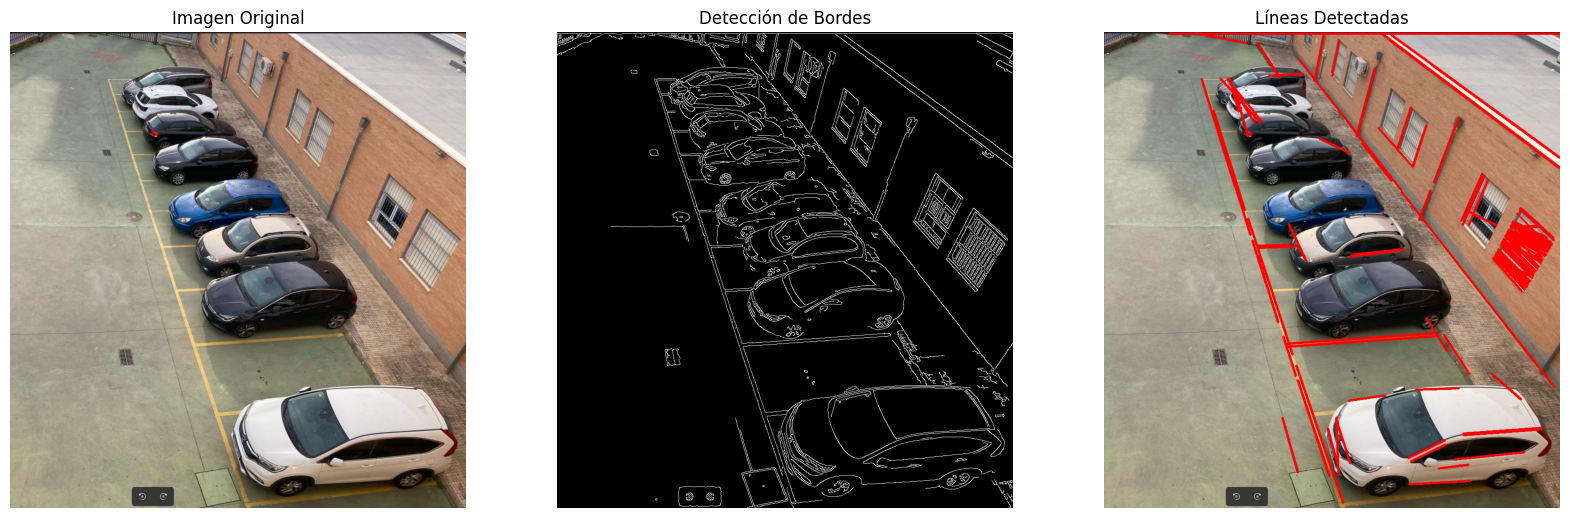

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_parking_rgb)
plt.title("Imagen Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("Detección de Bordes")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_lines)
plt.title("Líneas Detectadas")
plt.axis("off")

plt.show()

Este metodo no es del todo efectivo, aunque se modifiquen parametros pierde mucha información ya que tendríamos que hacer un modelo que enfoque la detección solo en una parte especifica de la imagen y eso sería inviable si tuviaramos otro tipo de imagen

# Detección de lineas con filtro amarillo

Para el siguiente metodo, he pensado que como las líneas de aparcamiento son amarillas simplemente vamos a aplicar una máscara amarilla en la que detectemos los umbrales de colores amarillos en esta. He intentado llegar al máximo punto en el que detecte que una línea es amarilla sin detectar otras pero aun así no lo he conseguido completamente

In [ ]:
# Convertir la imagen al espacio de color HSV
hsv = cv2.cvtColor(img_parking, cv2.COLOR_BGR2HSV)

# Definir el rango de color amarillo en HSV
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

# Crear una máscara para el color amarillo
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# Aplicar una operación morfológica para limpiar el ruido
kernel = np.ones((10, 10), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Aplicar la máscara a la imagen original
yellow_lines = cv2.bitwise_and(img_parking, img_parking, mask=mask_cleaned)

# Detectar bordes en la máscara limpia
edges_yellow = cv2.Canny(mask_cleaned, 50, 150)

# Detectar líneas en la imagen con máscara amarilla
lines_yellow = cv2.HoughLinesP(edges_yellow, 1, np.pi / 180, threshold=0, minLineLength=10, maxLineGap=20)

# Dibujar las líneas detectadas en la imagen original
img_yellow_lines = img_parking_rgb.copy()
if lines_yellow is not None:
    for line in lines_yellow:
        x1, y1, x2, y2 = line[0]
        cv2.line(img_yellow_lines, (x1, y1), (x2, y2), (255, 0, 0), 3)

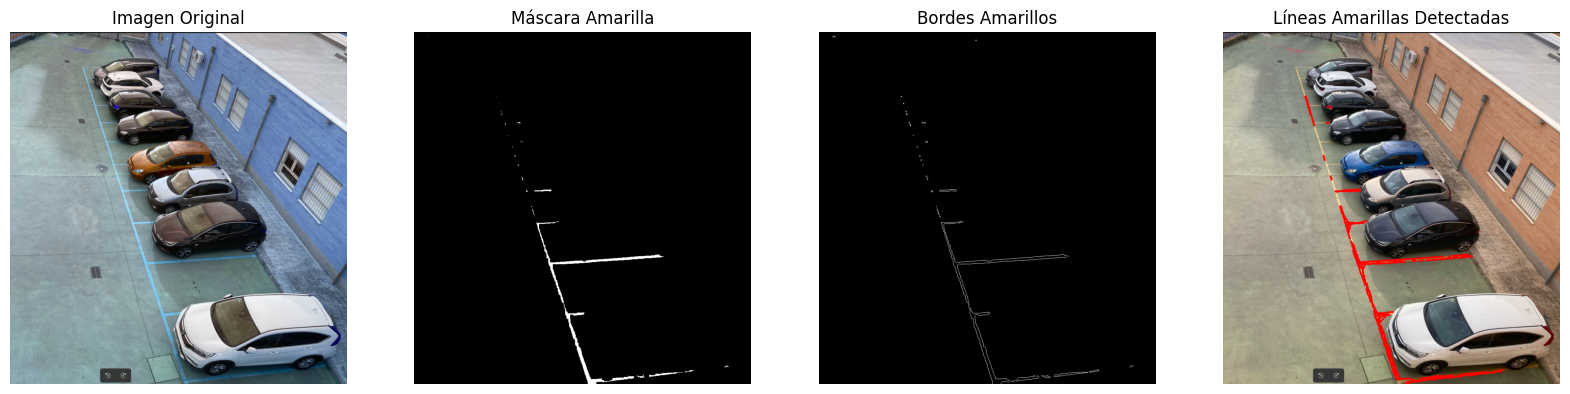

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(img_parking)
plt.title("Imagen Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(mask_cleaned, cmap='gray')
plt.title("Máscara Amarilla")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(edges_yellow, cmap='gray')
plt.title("Bordes Amarillos")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(img_yellow_lines)
plt.title("Líneas Amarillas Detectadas")
plt.axis("off")

plt.show()

Detecta bastante bien pero aun así faltan las restantes del fondo. Cuanto más alejadas esten más se confunden con otra escala de color
Creo que lo siguiente que voy a hacer es usar un modelo de redes neuronales de opencv (yolo) en este caso. Para detectar lo que es un coche. De esta manera podremos detectar las plazas ocupadas

### YOLO

In [ ]:
# Download YOLOv4 weights and config if they don't exist
if not os.path.exists("yolov4.weights"):
    urlretrieve("https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights", "yolov4.weights")
if not os.path.exists("yolov4.cfg"):
    urlretrieve("https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg", "yolov4.cfg")
if not os.path.exists("coco.names"):
    urlretrieve("https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names", "coco.names")


In [ ]:
# Cargar modelo YOLO
net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Cargar nombres de clases
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Cargar imagen
img = cv2.imread("parking.png")
height, width, _ = img.shape

# Convertir a blob y alimentar la red
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

YOLO model can sometimes detect the same car multiple times due to overlapping bounding boxes or the way the model identifies objects. To address this, we can use a technique called Non-Maximum Suppression (NMS). NMS is a post-processing step that helps filter out redundant bounding boxes, keeping only the most confident one for each actual object.

In [ ]:
# Lists to store detection info
boxes = []
confidences = []
class_ids = []

# Analizar detecciones
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # If the object detected is a car
        if classes[class_id] == "car":
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

# Apply Non-Maximum Suppression (NMS)
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

Separate Lists:

boxes, confidences, and class_ids lists are created to store the bounding box coordinates, confidence scores, and class IDs of detected objects before NMS is applied.
Populating the Lists:

When a car is detected (if classes[class_id] == "car" is true), the bounding box, confidence, and class ID information are appended to the boxes, confidences and class_ids lists respectively.
cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4):

This is the core of the fix. cv2.dnn.NMSBoxes applies NMS.
boxes: The list of bounding box coordinates.
confidences: The list of corresponding confidence scores.
0.5: The confidence threshold, used to filter out low-confidence detections before NMS.
0.4: The NMS threshold (IoU threshold). Boxes that overlap with an IoU greater than this are suppressed.
The function returns indices, which represents the indices of the bounding boxes that should be kept after NMS.
Process After NMS:

The code checks if the indices list is empty, and if it is not empty it loops through the indices list, to get the coordinates and the cv2.rectangle can be used to draw only the bounding box that pass the NMS. It also stores the car detections in car_detections.

Number of cars detected: 8
Car 1: x=387, y=382, width=260, height=132
Car 2: x=402, y=476, width=322, height=165
Car 3: x=299, y=217, width=221, height=105
Car 4: x=329, y=307, width=261, height=124
Car 5: x=463, y=731, width=470, height=249
Car 6: x=261, y=120, width=172, height=73
Car 7: x=276, y=165, width=164, height=79
Car 8: x=239, y=72, width=187, height=76


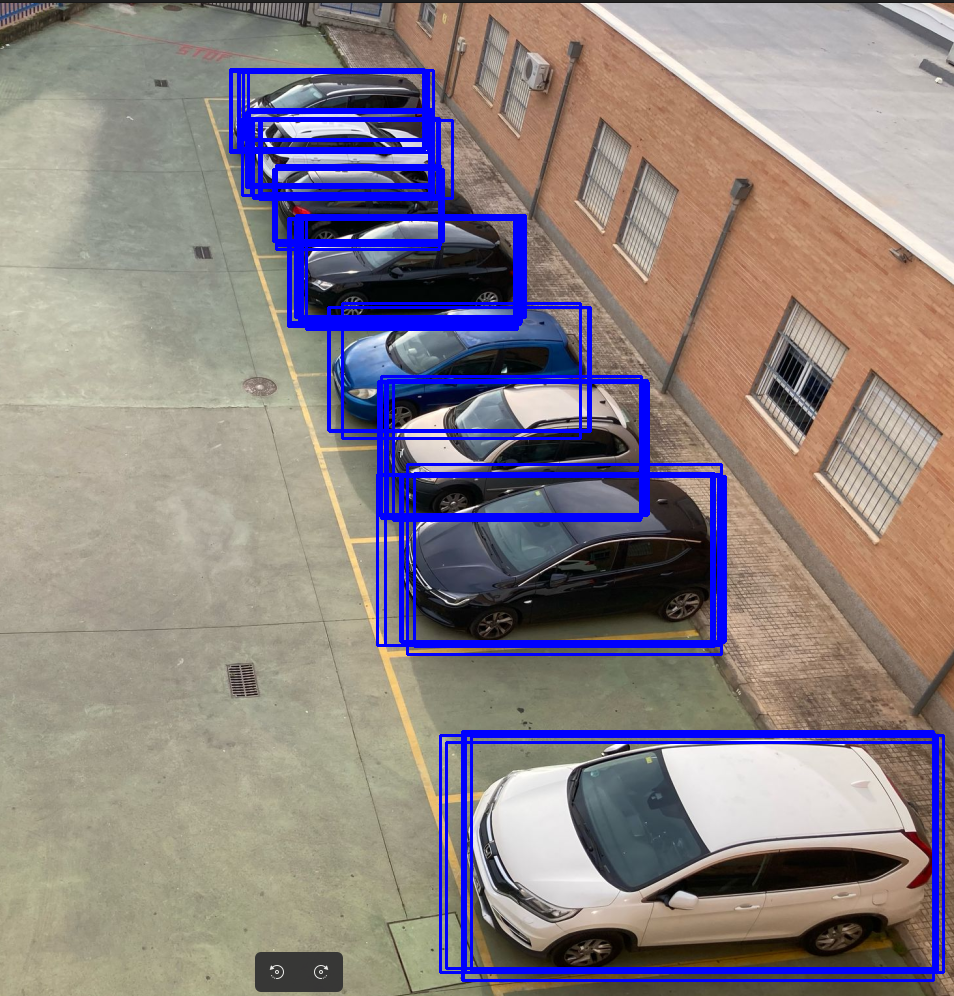

In [ ]:
# Initialize a list to store car detections
car_detections = []

# Process the detections after NMS
if len(indices) > 0:
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        car_detections.append({"x": x, "y": y, "width": w, "height": h})
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Print the number of cars detected
print(f"Number of cars detected: {len(car_detections)}")
# Print the location of each car
for i, detection in enumerate(car_detections):
    print(f"Car {i + 1}: x={detection['x']}, y={detection['y']}, width={detection['width']}, height={detection['height']}")

# Mostrar imagen
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

How NMS Works:

Confidence Thresholding: First, NMS removes any bounding boxes with confidence scores below a specified threshold (in our case, 0.5).
IoU Calculation: Then, it calculates the Intersection over Union (IoU) between all remaining bounding boxes. IoU measures how much two boxes overlap.
Suppression: If the IoU between two boxes is higher than the specified NMS threshold (in our case, 0.4), the box with the lower confidence score is suppressed. This process is repeated until no more suppressions are possible.
Output: The bounding boxes that remain after NMS are the ones considered as final detections.
Adjusting NMS Parameters:

Confidence Threshold (0.5): You can adjust this based on the confidence scores you are getting from your model. Increase if you see too many false positives, decrease if you miss valid detections.
NMS Threshold (0.4): This controls how aggressive the suppression is. Lower values mean that fewer overlapping boxes will be suppressed, while higher values can suppress detections more aggressively. You might need to adjust this value based on how well the bounding boxes fit the objects in your image. A good range is often between 0.3 and 0.6.

In [ ]:
def count_empty_spots(img_yellow_lines, car_detections):
    try:
        total_parking_spots = 12  # img_yellow_lines
        occupied_spots = len(car_detections)
        empty_spots = total_parking_spots - occupied_spots

        return empty_spots

    except Exception as e:
        print(f"An error occurred: {e}")
        return -1

empty_spots = count_empty_spots(img_yellow_lines, car_detections)
if empty_spots != -1:
  print(f"Number of empty parking spots: {empty_spots}")

Number of empty parking spots: 4
